https://github.com/sunilgoda/nn_text_classification/blob/master/notebooks/NeuralNetworks_TextClassification.ipynb

In [5]:
!ls

sample_data


In [103]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras as k

from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, Flatten,Dropout,BatchNormalization,Lambda
from keras.layers import Conv1D,MaxPool1D,GlobalMaxPool1D,Embedding
from keras.layers import LSTM,GRU,RNN
from keras.models import Sequential
from keras.optimizers import Adam, Adagrad,Adadelta,Nadam
from keras import callbacks
from keras import regularizers
from keras.utils import plot_model
from keras.models import load_model
from sklearn.metrics import classification_report

from matplotlib import pyplot as plt 
%matplotlib inline

In [74]:
from google.colab import files
test = files.upload()

Saving facebook_health_cases (original v4.1).csv to facebook_health_cases (original v4.1).csv


In [8]:
test = files.upload()

Saving facebook_health_cases (val v4).csv to facebook_health_cases (val v4).csv


In [9]:
test = files.upload()

Saving facebook_health_cases (test v4).csv to facebook_health_cases (test v4).csv


In [10]:
!ls

'facebook_health_cases (augmented v4.1).csv'
'facebook_health_cases (test v4).csv'
'facebook_health_cases (val v4).csv'
 sample_data


In [142]:
texts = pd.read_csv('facebook_health_cases (augmented v4.1) (1).csv')
df_train = pd.DataFrame(texts)
df_train.head()

,date,text,cleaned,sentiment
0,20210420,LOL....u mean the country is still in first wa...,lol u mean the country is still the first wave...,negative
1,20210420,LOL....u mean the country is still in first wa...,lol u middle country always first wave because...,negative
2,20210420,LOL....u mean the country is still in first wa...,lol u means country even first wave because pr...,negative
3,20210420,LOL....u mean the country is still in first wa...,lol u my country still first wave because prev...,negative
4,20210420,LOL....u mean the country is still in first wa...,lol you mean the country is still the first wa...,negative


In [143]:
df_train = df_train.drop_duplicates(subset=['cleaned'])
df_train.shape

(28156, 4)

In [144]:
texts = pd.read_csv('facebook_health_cases (val v4).csv')
df_val = pd.DataFrame(texts)
df_val.head()

,date,text,cleaned,sentiment
0,20210222,peliknye perak trun mendadak..dr 1k++ trun ke ...,peliknya perak turun mendadak ribu turun,negative
1,20210212,dalam majlis yg dihadiri menteri ramai je yang...,majlis dihadiri menteri ramai tidak pakai mask...,negative
2,20210222,akhirnya selangor merampas kembali ranking per...,selangor merampas ranking studio,neutral
3,20210107,emmm 3k...tp masih ada lagi sesetengah rakyat ...,em ribu sesetengah rakyat malaysia enjoy bercu...,negative
4,20210303,Kes baru dh kluster tmpt keje jer byk mcm kila...,kes kluster kerja banyak kilang pembinaan dibe...,negative


In [145]:
texts = pd.read_csv('facebook_health_cases (test v4).csv')
df_test = pd.DataFrame(texts)
df_test.head()

,date,text,cleaned,sentiment
0,20210306,Alhamdulillah hari demi hari covid semakin ber...,covid berkurangan semoga sambut ramadhan tanpa...,positive
1,20210106,masih terkawal lagi sebab belum sampai 3000 💩💩💩,terkawal belum,negative
2,20210205,tutup je utk 7-10hari(lockdown cam pkp 1.0...m...,tutup lockdown pkp mac jangan penduduk menangi...,negative
3,20210123,seronok pkp kalini... meriah jer atas jalan ra...,seronok pkp kali meriah jalan raya sambut merdeka,negative
4,20210204,selangor masih mengungguli carta.. tahniah unt...,selangor mengungguli carta tahniah red giant,negative


In [146]:
train_frames = [df_train, df_test, df_val]
df_all = pd.concat(train_frames)

In [147]:
df_all

,date,text,cleaned,sentiment
0,20210420,LOL....u mean the country is still in first wa...,lol u mean the country is still the first wave...,negative
1,20210420,LOL....u mean the country is still in first wa...,lol u middle country always first wave because...,negative
2,20210420,LOL....u mean the country is still in first wa...,lol u means country even first wave because pr...,negative
3,20210420,LOL....u mean the country is still in first wa...,lol u my country still first wave because prev...,negative
4,20210420,LOL....u mean the country is still in first wa...,lol you mean the country is still the first wa...,negative
...,...,...,...,...
727,20210418,Bacause our leaders busy die2 want election ev...,bacause leaders busy die want election even co...,negative
728,20210420,No 4th wave... But got 3rd wave 2.0,nofourthwave gotthirdwave,negative
729,20210416,Now many cases happened in schools.,many cases happened schools,negative
730,20210416,I hope our YB Ismail Sabri cannot b too compla...,hope yb ismail sabri cannot b complacement com...,negative


In [148]:
print("Max length: %s" %df_all.cleaned.str.len().max())
print("Mean length: %s" %df_all.cleaned.str.len().mean())
print("Min length: %s" %df_all.cleaned.str.len().min())

Max length: 1548
Mean length: 112.94143064510685
Min length: 2


In [149]:
MAX_SEQ_LEN = 1300
VOCAB_SIZE = 100000

- fits_on_texts:

Updates internal vocabulary based on a list of texts.

In the case where texts contains lists, we assume each entry of the lists to be a token.

Required before using texts_to_sequences or texts_to_matrix.


- texts_to_sequences:

Transforms each text in texts to a sequence of integers.

Only top num_words-1 most frequent words will be taken into account. Only words known by the tokenizer will be taken into account.

In [150]:
tokenizer = Tokenizer(num_words = VOCAB_SIZE)
tokenizer.fit_on_texts(df_all.cleaned)

train_sequences = tokenizer.texts_to_sequences(df_train.cleaned)
val_sequences = tokenizer.texts_to_sequences(df_val.cleaned)
test_sequences = tokenizer.texts_to_sequences(df_test.cleaned)

That + 1 is because of reserving padding (i.e. index zero).

In [151]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 19259 unique tokens.


In [152]:
train_data = pad_sequences(train_sequences, maxlen= MAX_SEQ_LEN)
val_data = pad_sequences(val_sequences, maxlen= MAX_SEQ_LEN)
test_data = pad_sequences(test_sequences, maxlen= MAX_SEQ_LEN)
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

(28156, 1300)
(732, 1300)
(735, 1300)


(row, max_seq_len) 

In [153]:
train_labels = df_train.sentiment

In [154]:
train_labels

0        negative
1        negative
2        negative
3        negative
4        negative
           ...   
29623     neutral
29624    negative
29625    negative
29626    negative
29627    negative
Name: sentiment, Length: 28156, dtype: object

In [155]:
label_encoder = LabelEncoder()
label_encoder.fit(train_labels)
train_labels = label_encoder.transform(train_labels)

print(label_encoder.classes_)

['negative' 'neutral' 'positive']


In [156]:
train_labels

array([0, 0, 0, ..., 0, 0, 0])

In [157]:
#convert to labels to one-hot-coded
train_tensor = to_categorical(np.array(train_labels))

print("Train tensor shape:",train_data.shape)
print("Train labels tensor shape:",train_tensor.shape)

Train tensor shape: (28156, 1300)
Train labels tensor shape: (28156, 3)


In [158]:
val_labels = df_val.sentiment

label_encoder = LabelEncoder()
label_encoder.fit(val_labels)
val_labels = label_encoder.transform(val_labels)

print(label_encoder.classes_)

val_tensor = to_categorical(np.array(val_labels))

print("Validation tensor shape:",val_data.shape)
print("validation labels tensor shape:",val_tensor.shape)

['negative' 'neutral' 'positive']
Validation tensor shape: (732, 1300)
validation labels tensor shape: (732, 3)


In [159]:
EMBEDDING_DIM = 100
INITIALIZER = 'he_uniform'
REGULARIZER = regularizers.l2(0.01)

cnn_model = Sequential()
cnn_model.add(Embedding(input_dim= VOCAB_SIZE, 
                    output_dim= EMBEDDING_DIM ,
                    input_length= MAX_SEQ_LEN,
                    embeddings_regularizer = REGULARIZER
                   ))
cnn_model.add(Conv1D(filters= 64, kernel_size= 3,activation= 'relu',
                 kernel_initializer= INITIALIZER ,
                 #kernel_regularizer= REGULARIZER
                ))
cnn_model.add(Conv1D(filters= 64, kernel_size= 5,activation= 'relu',
                 kernel_initializer= INITIALIZER,
                 #kernel_regularizer= REGULARIZER
                 ))
cnn_model.add(GlobalMaxPool1D())
#cnn_model.add(MaxPool1D())
cnn_model.add(Dropout(0.2))
cnn_model.add(BatchNormalization())

#cnn_model.add(Conv1D(filters= 64, kernel_size= 5,activation= 'relu',padding = 'same'))
#cnn_model.add(Conv1D(filters= 64, kernel_size= 5,activation= 'relu',padding = 'same'))

cnn_model.add(Dense(128, activation= 'relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(BatchNormalization())
cnn_model.add(Dense(3,activation= 'softmax'))

In [160]:
adam = Adam(lr=0.001)
#adagrad = Adagrad()
#adadelta = Adadelta()
#nadam = Nadam(lr=0.001)
cnn_model.compile(loss = 'categorical_crossentropy',
             optimizer = adam,
             metrics = ['accuracy']
             )

cnn_model.summary()
metric = "val_accuracy"

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 1300, 100)         10000000  
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 1298, 64)          19264     
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 1294, 64)          20544     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 64)                0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 64)                256       
_________________________________________________________________
dense_8 (Dense)              (None, 128)              

### Define Callback

In [161]:
reduce_lr = callbacks.ReduceLROnPlateau(monitor= metric, factor= 0.1,
                                       patience= 10, min_lr= 0.00001,
                                       verbose= 1)

early_stop = callbacks.EarlyStopping(monitor= metric, mode= 'auto',
                                     patience= 15,
                                    verbose= 1)
                                    #restore_best_weights= True)

#file_path = "cnn_weights.{epoch:02d}-{val_loss:.2f}.hdf5"
file_path = "cnn_weights.hdf5"
model_chkpt = callbacks.ModelCheckpoint(filepath=file_path,monitor= metric, save_best_only=True)

In [162]:
history = cnn_model.fit(train_data , train_tensor ,
         batch_size = 64, shuffle = True,
         epochs=1000,
         validation_data = (val_data, val_tensor),
         callbacks = [reduce_lr,early_stop,model_chkpt]
         )

Epoch 1/1000
440/440 [==============================] - 37s 81ms/step - loss: 12.8772 - accuracy: 0.5646 - val_loss: 1.2034 - val_accuracy: 0.7473
Epoch 2/1000
440/440 [==============================] - 35s 80ms/step - loss: 1.0228 - accuracy: 0.7823 - val_loss: 1.1637 - val_accuracy: 0.7568
Epoch 3/1000
440/440 [==============================] - 35s 80ms/step - loss: 0.9751 - accuracy: 0.8171 - val_loss: 1.1779 - val_accuracy: 0.7801
Epoch 4/1000
440/440 [==============================] - 35s 79ms/step - loss: 0.9611 - accuracy: 0.8453 - val_loss: 1.2691 - val_accuracy: 0.7623
Epoch 5/1000
440/440 [==============================] - 35s 80ms/step - loss: 0.9601 - accuracy: 0.8553 - val_loss: 1.2687 - val_accuracy: 0.7541
Epoch 6/1000
440/440 [==============================] - 35s 80ms/step - loss: 0.9229 - accuracy: 0.8730 - val_loss: 1.2094 - val_accuracy: 0.7705
Epoch 7/1000
440/440 [==============================] - 35s 81ms/step - loss: 0.8483 - accuracy: 0.8867 - val_loss: 1.3153 

In [163]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

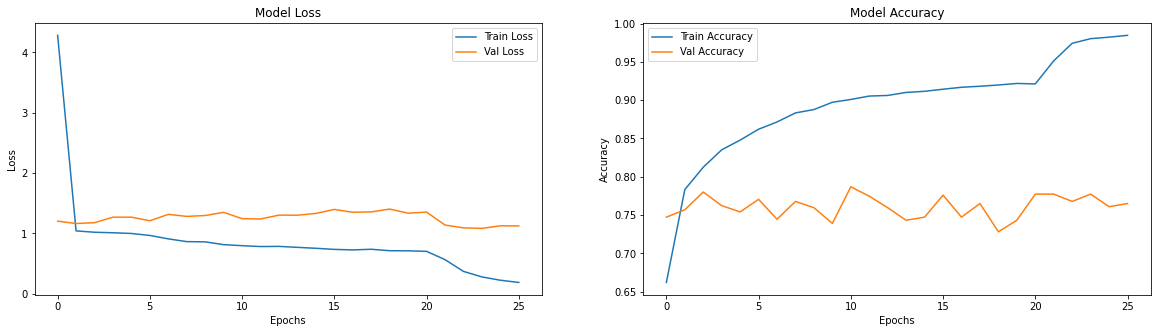

In [164]:
plt.figure(figsize=(20,5))
ax = plt.subplot(1,2,1)
ax.set_title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_loss , label ="Train Loss")
plt.plot(val_loss, label ="Val Loss")
plt.legend()

ax = plt.subplot(1,2,2)
ax.set_title("Model Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(train_acc, label = "Train Accuracy")
plt.plot(val_acc, label = "Val Accuracy")
plt.legend()
plt.show();

In [165]:
evaluation = cnn_model.evaluate(train_data,train_tensor)
print("Train Loss: %f"%evaluation[0] , "Train Accuracy: %f"%evaluation[1])

880/880 [==============================] - 23s 26ms/step - loss: 0.1482 - accuracy: 0.9962
Train Loss: 0.148229 Train Accuracy: 0.996200


In [166]:
test_labels = df_test.sentiment
label_encoder = LabelEncoder()
label_encoder.fit(df_test.sentiment)
test_labels = label_encoder.transform(test_labels)

test_tensor = to_categorical(np.array(test_labels))

loss, accuracy = cnn_model.evaluate(test_data, test_tensor)
print("Testing Accuracy:  {:.4f}".format(accuracy))

23/23 [==============================] - 1s 26ms/step - loss: 0.9515 - accuracy: 0.7864
Testing Accuracy:  0.7864


In [167]:
best_weights_cnn = load_model(file_path)
loss, accuracy = best_weights_cnn.evaluate(test_data, test_tensor)
print("Testing Accuracy:  {:.4f}".format(accuracy))

23/23 [==============================] - 1s 27ms/step - loss: 1.1172 - accuracy: 0.7973
Testing Accuracy:  0.7973


In [168]:
# with best weight
evaluation = best_weights_cnn.evaluate(train_data,train_tensor)
print("Train Loss: %f"%evaluation[0] , "Train Accuracy: %f"%evaluation[1])

880/880 [==============================] - 23s 26ms/step - loss: 0.6974 - accuracy: 0.9446
Train Loss: 0.697415 Train Accuracy: 0.944630


In [169]:
y_pre=best_weights_cnn.predict(test_data)

In [170]:
scores = []
for i in y_pre:
  scores.append(np.where(i == np.amax(i))[0][0])

In [171]:
print(classification_report(y_true = test_labels, y_pred = scores))

              precision    recall  f1-score   support

           0       0.85      0.88      0.87       452
           1       0.37      0.46      0.41        83
           2       0.90      0.74      0.81       200

    accuracy                           0.80       735
   macro avg       0.71      0.70      0.70       735
weighted avg       0.81      0.80      0.80       735



In [172]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [173]:
y_true = np.array(test_labels)

In [174]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_true, scores)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_true, scores, average='macro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_true, scores, average='macro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_true, scores, average='macro')
print('F1 score: %f' % f1)

Accuracy: 0.797279
Precision: 0.708176
Recall: 0.695192
F1 score: 0.697785


In [72]:
sub=pd.DataFrame({'check':df_test.cleaned.values.tolist(),'target':df_test.sentiment.values.tolist(),'predicted':scores})

In [73]:
sub.to_csv('cnn_check_test.csv',index=False)
files.download('cnn_check_test.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
y_pre=best_weights_cnn.predict(val_data)

scores = []
for i in y_pre:
  scores.append(np.where(i == np.amax(i))[0][0])

sub=pd.DataFrame({'check':df_val.check.values.tolist(),'target':df_val.sentiment.values.tolist(),'predicted':scores})
sub.to_csv('cnn_check_val.csv',index=False)
files.download('cnn_check_val.csv')

In [ ]:
files.download(file_path) #download model